# Standard RB Demo

This is a very basic implemention of a standard RB experiment

In [1]:
import numpy as np
import qiskit_experiments as qe
import qiskit.circuit.library as circuits
rb = qe.randomized_benchmarking

# For simulation
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeParis

backend = AerSimulator.from_backend(FakeParis())

## Running 1-qubit RB

---------------------------------------------------
Experiment: StandardRB
Experiment ID: abb171ea-4832-4f27-827f-7c39a97d9d5f
Status: DONE
Circuits: 140
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.47586241702287474 ± 0.009243502766339203
- alpha: 0.9927811777627263 ± 0.00042104614423724585
- b: 0.5083682695263522 ± 0.009240983643318724
- analysis_type: RBAnalysis
- reduced_chisq: 0.10234904660797374
- dof: 11
- xrange: [1.0, 500.0]
- EPC: 0.0036094111186368294
- EPC_err: 0.00021205385117498442
- EPG: {0: {'rz': 0.0, 'sx': 0.0004296292767646568, 'x': 0.0004296292767646568}}
- success: True


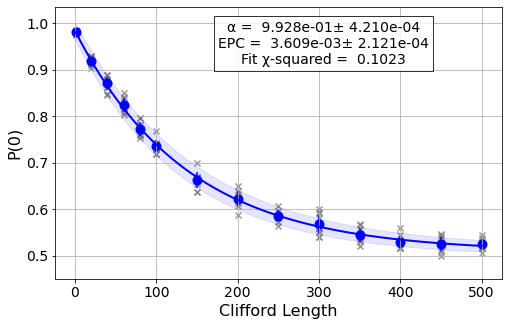

In [2]:
lengths = [1, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]
num_samples = 10
seed = 1010

# Run an RB experiment on qubit 0
exp1 = rb.StandardRB([0], lengths, num_samples=num_samples, seed=seed)
expdata1 = exp1.run(backend)

# View result data
print(expdata1)

## Running 2-qubit RB

---------------------------------------------------
Experiment: StandardRB
Experiment ID: f358277d-3a52-4cd6-8a7e-05c24a6762c3
Status: DONE
Circuits: 100
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.7092998346720112 ± 0.016461635504723907
- alpha: 0.9581638946178486 ± 0.0022139281166715066
- b: 0.2607027362185362 ± 0.00651581614212633
- analysis_type: RBAnalysis
- reduced_chisq: 0.09649938971985716
- dof: 7
- xrange: [1.0, 200.0]
- EPC: 0.031377079036613575
- EPC_err: 0.0017329457902041673
- EPG: {(0, 1): {'cx': 0.02061926816238576}}
- success: True


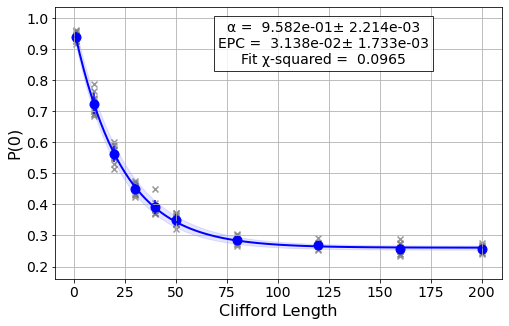

In [3]:
lengths = [1, 10, 20, 30, 40, 50, 80, 120, 160, 200]
num_samples = 10
seed = 1010

# Run an RB experiment on qubits 0, 1
exp2 = rb.StandardRB([0, 1], lengths, num_samples=num_samples, seed=seed)
expdata2 = exp2.run(backend)

# View result data
print(expdata2)

# Using 1-qubit EPG results to improve 2-qubit EPG results

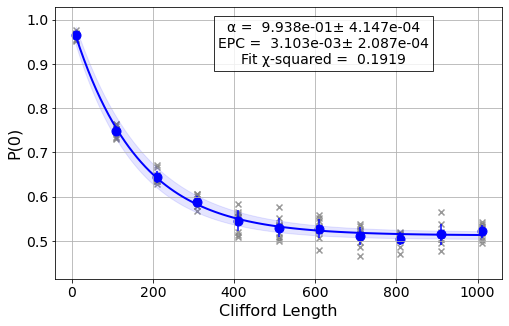

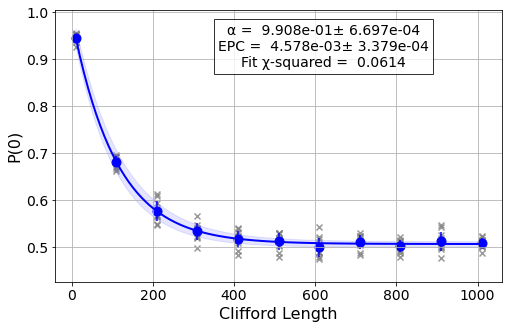

In [4]:
lengths_1_qubit = np.arange(10,1020,100)
lengths_2_qubit = np.arange(10,220,30)
num_samples = 10
seed = 1010
qubits = (1,4)

# Run an RB experiment on qubit 0
epg_data = {}
for qubit in qubits:
    exp = rb.StandardRB([qubit], lengths_1_qubit, num_samples=num_samples, seed=seed)
    expdata = exp.run(backend)
    epg_data[qubit] = expdata.analysis_result(0)['EPG'][qubit]

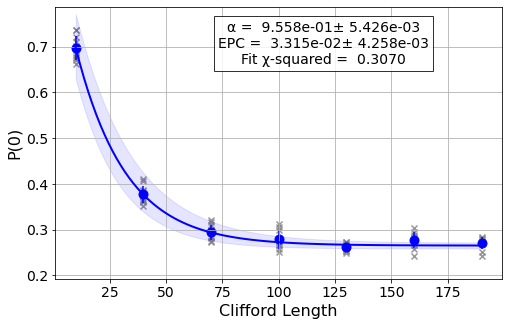

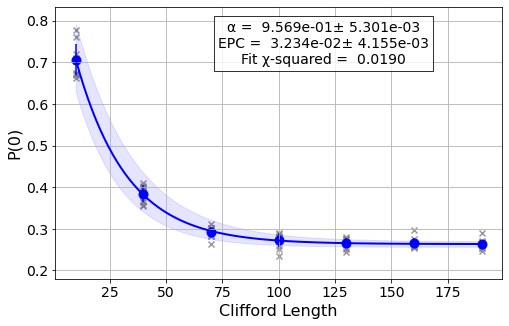

In [5]:
exp2 = rb.StandardRB(qubits, lengths_2_qubit, num_samples=num_samples, seed=seed)
exp2data = exp2.run(backend)
exp2.set_analysis_options(epg_1_qubit=epg_data)
exp2data_with_1_qubit_epg = exp2.run(backend)

In [6]:
expected_epg = rb.RBUtils.get_error_dict_from_backend(backend, qubits)[(qubits, 'cx')]
exp2_epg = exp2data.analysis_result(0)['EPG'][qubits]['cx']
exp2_with_1_qubit_epg = exp2data_with_1_qubit_epg.analysis_result(0)['EPG'][qubits]['cx']
print("Expected EPG:", expected_epg)
print("EPG without 1-qubit EPG data:", exp2_epg)
print("EPG with 1-qubit EPG data:", exp2_with_1_qubit_epg)

Expected EPG: 0.012438847900902494
EPG without 1-qubit EPG data: 0.021673037315344316
EPG with 1-qubit EPG data: 0.011444117046657987


In [7]:
exp2data.analysis_result(0)['EPG'][qubits]['cx']

0.021673037315344316

In [8]:
qubits = (1,4)
rb.RBUtils.get_error_dict_from_backend(backend, qubits)[(qubits, 'cx')]

0.012438847900902494

# Running 1-qubit Interleaved RB

---------------------------------------------------
Experiment: InterleavedRB
Experiment ID: bbd67093-d6a6-463f-b787-134ba820f6f9
Status: DONE
Circuits: 280
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.47580366098951155 ± 0.006389240527402218
- alpha: 0.9926930379087018 ± 0.0003385573113866431
- alpha_c: 0.9989341146728349 ± 0.0003587158293220564
- b: 0.5102782171549338 ± 0.006095952053327467
- analysis_type: InterleavedRBAnalysis
- reduced_chisq: 0.1931421217759649
- dof: 24
- xrange: [1.0, 500.0]
- EPC: 0.0005329426635825585
- EPC_err: 0.0001793579146610282
- EPC_systematic_err: 0.006774019427715661
- EPC_systematic_bounds: [0, 0.007306962091298219]
- success: True


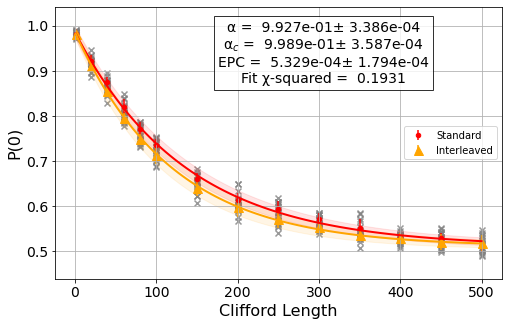

In [9]:
lengths = [1, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]
num_samples = 10
seed = 1010

# Run an RB experiment on qubit 0
int_exp1 = rb.InterleavedRB(circuits.XGate(), [0], lengths, num_samples=num_samples, seed=seed)
int_expdata1 = int_exp1.run(backend)

# View result data
print(int_expdata1)

# Running 2-qubit Interleaved RB

---------------------------------------------------
Experiment: InterleavedRB
Experiment ID: ef2a9d0b-7704-4bea-aee0-d61612e4be37
Status: DONE
Circuits: 200
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.6948284301386051 ± 0.015698124197997907
- alpha: 0.9547923700734239 ± 0.002413854079099701
- alpha_c: 0.985475251742841 ± 0.003975361488014038
- b: 0.2624967237356325 ± 0.004585180000570928
- analysis_type: InterleavedRBAnalysis
- reduced_chisq: 0.10311111126460995
- dof: 16
- xrange: [1.0, 200.0]
- EPC: 0.010893561192869244
- EPC_err: 0.0029815211160105284
- EPC_systematic_err: 0.056917883696994936
- EPC_systematic_bounds: [0, 0.06781144488986418]
- success: True


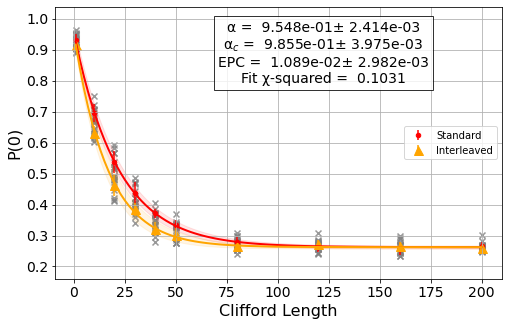

In [10]:
lengths = [1, 10, 20, 30, 40, 50, 80, 120, 160, 200]
num_samples = 10
seed = 1010

# Run an Interleaved RB experiment on qubits 4, 6
int_exp2 = rb.InterleavedRB(circuits.CXGate(), [4,6], lengths, num_samples=num_samples, seed=seed)
int_expdata2 = int_exp2.run(backend)

# View result data
print(int_expdata2)

## Running parallel RB experiments

---------------------------------------------------
Experiment: ParallelExperiment
Experiment ID: 2e655705-78cd-4169-ab86-9344a92db2b1
Status: DONE
Component Experiments: 5
Circuits: 140
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- experiment_types: ['StandardRB', 'StandardRB', 'StandardRB', 'StandardRB', 'StandardRB']
- experiment_ids: ['e15ad508-7863-4c15-bac4-def3491f0f08', 'dd360f5e-eae5-4ef2-bbc4-26fa526a2e98', '7a27824e-1faf-4cb5-95e3-17587a9b53e7', '0eb28512-1818-4180-8749-1d1710154c97', 'b6df2b5b-a9c5-49f8-bf7a-25a8cda92a35']
- experiment_qubits: [(0,), (1,), (2,), (3,), (4,)]
- success: True


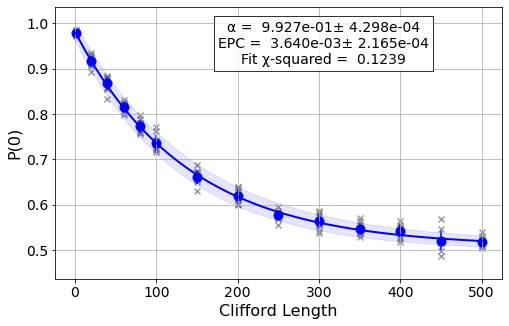

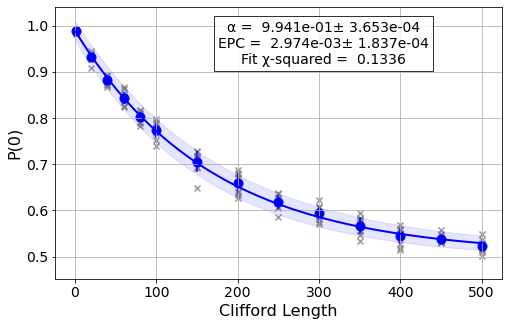

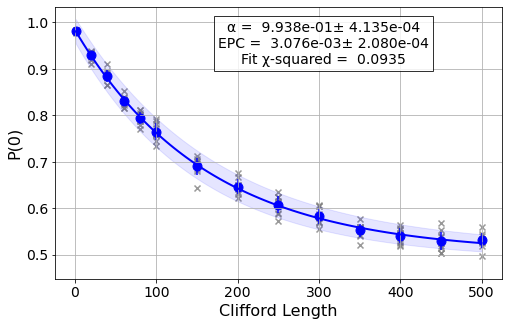

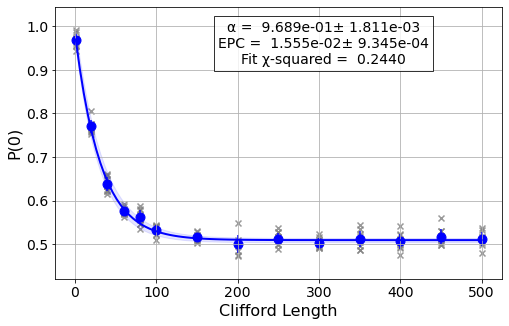

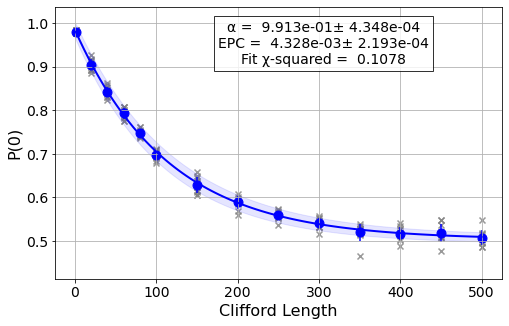

In [11]:
lengths = [1, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]
num_samples = 10
seed = 1010

exps = [rb.StandardRB([i], lengths, num_samples=num_samples, seed=seed + i)
        for i in range(5)]

par_exp = qe.composite.ParallelExperiment(exps)
par_expdata = par_exp.run(backend)

# View result
print(par_expdata)

#### Viewing sub experiment data

The experiment data returned from a batched experiment also contains individual experiment data for each sub experiment which can be accessed using `experiment_data(index)`

In [12]:
# Print sub-experiment data
for i in range(par_exp.num_experiments):
    print(par_expdata.component_experiment_data(i), '\n')

---------------------------------------------------
Experiment: StandardRB
Experiment ID: e15ad508-7863-4c15-bac4-def3491f0f08
Status: DONE
Circuits: 140
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.47474586774131516 ± 0.009513862781647961
- alpha: 0.992719740801685 ± 0.0004297522116956945
- b: 0.5074248552811815 ± 0.009344432974665095
- analysis_type: RBAnalysis
- reduced_chisq: 0.12385735954117955
- dof: 11
- xrange: [1.0, 500.0]
- EPC: 0.0036401295991574933
- EPC_err: 0.00021645193201690638
- EPG: {0: {'rz': 0.0, 'sx': 0.0004332857066186177, 'x': 0.0004332857066186177}}
- success: True 

---------------------------------------------------
Experiment: StandardRB
Experiment ID: dd360f5e-eae5-4ef2-bbc4-26fa526a2e98
Status: DONE
Circuits: 140
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.4847896780838331 ± 0.010294167129062686
- alpha: 0.9940529778584196 ± 0.0003652708542941224
-